>> 1. 모델 작성

수치형 데이터의 모델을 만드는 방법을 알아봅시다. 

부동산 가격에 대한 선형 모델을 만들어보겠습니다. 

보스톤의 부동산 가격 데이터셋을 활용하겠습니다. 

다운로드 링크
https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


각 컬럼은 아래와 같이 정의됩니다. 

부동산 가격에 영향을 미칠만한 요소들이며, 부동산 가격은 MEDV 컬럼에 표시되었습니다. 


```
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000s
```

In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/AI_한기대/housing.csv', sep = '\s+', header = None) # \s+는 space 나 tab 이 섞여있을 때, 데이터에 컬럼명이 없음

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
len(df)

506

데이터를 train과 test set으로 나누어봅시다. 

우선 특성과 target을 나누어주도록 하겠습니다. 

In [4]:
from sklearn.model_selection import train_test_split
x = df.iloc[:,:-1].values  # 마지막에 있는 MEDV 컬럼 제외
y = df.MEDV.values # MEDV 컬럼 

print(x.shape)
print(y.shape)


(506, 13)
(506,)


머신러닝 라이브러리인 sklearn의 train_test_split 함수를 이용하여 train, test 데이터를 나눕니다. 여기서는 30%를 test 셋으로 하겠습니다. 

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)  # 30%를 테스트셋으로 분할


Tensorflow를 사용하여 부동산 가격을 예측하는 모델을 만들어보겠습니다. 


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers

각 컬럼별로 값의 범위가 다르니 표준화를 진행하도록 하겠습니다. 

In [7]:
x_train_mean = x_train.mean(axis = 0)   # column별로 평균 및 표준편차 구하여 표준화, 축이 맞게 되어 있는지 확인할 것
x_train_std = x_train.std(axis = 0)

In [8]:
print(x_train_mean)
print(x_train_std)

[3.04064743e+00 1.31765537e+01 1.07014124e+01 7.90960452e-02
 5.45993503e-01 6.30973164e+00 6.66635593e+01 3.95585113e+00
 8.89548023e+00 3.97062147e+02 1.83782486e+01 3.59534266e+02
 1.22105932e+01]
[7.18580232e+00 2.48157456e+01 6.83823339e+00 2.69888608e-01
 1.16183423e-01 7.33325510e-01 2.85721398e+01 2.18007659e+00
 8.41862557e+00 1.64187923e+02 2.15238832e+00 8.90075226e+01
 7.34308953e+00]


테스트셋의 평균 및 표준편차는 학습 시점에 알기 어려운 것이니
학습 데이터셋의 평균과 표준편차를 이용하여 표준화하겠습니다. 

In [9]:
x_train_scaled = (x_train - x_train_mean)/x_train_std
x_test_scaled = (x_test - x_train_mean)/x_train_std

In [10]:
x_train_scaled.max()

9.028936465930776

In [11]:
x_train_scaled.min()

-4.035774223410433

딥러닝 모델을 만들어 봅시다.

기존에 이미지와는 달리 이번에는 입력의 모양이 이미지보다 한 차원 작습니다. 

출력결과는 부동산 가격(MEDV) 값 하나가 나와야 하므로 마지막 레이어의 unit size를 1로 합니다 .

Dense Layer로 구성되어 있는 모델을 만들겠습니다. 

In [13]:
model = tf.keras.Sequential([
    layers.Dense(64,input_shape=[13]), # 13개의 컬럼
    layers.Dense(32,),
    layers.Dense(1)
  ])


model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                896       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit( x_train_scaled, y_train, epochs=30, validation_split = 0.2, callbacks = [callback])

Epoch 1/30
9/9 [==============================] - 1s 26ms/step - loss: 580.8680 - mse: 580.8680 - mae: 22.7417 - val_loss: 653.3310 - val_mse: 653.3310 - val_mae: 23.5685
Epoch 2/30
9/9 [==============================] - 0s 5ms/step - loss: 560.4493 - mse: 560.4493 - mae: 22.5081 - val_loss: 629.4706 - val_mse: 629.4706 - val_mae: 23.3605
Epoch 3/30
9/9 [==============================] - 0s 6ms/step - loss: 545.0989 - mse: 545.0989 - mae: 22.3279 - val_loss: 602.2765 - val_mse: 602.2765 - val_mae: 23.1025
Epoch 4/30
9/9 [==============================] - 0s 7ms/step - loss: 528.2217 - mse: 528.2217 - mae: 22.0608 - val_loss: 576.5187 - val_mse: 576.5187 - val_mae: 22.7744
Epoch 5/30
9/9 [==============================] - 0s 7ms/step - loss: 509.0806 - mse: 509.0806 - mae: 21.7238 - val_loss: 552.9196 - val_mse: 552.9196 - val_mae: 22.4070
Epoch 6/30
9/9 [==============================] - 0s 9ms/step - loss: 491.0283 - mse: 491.0283 - mae: 21.3714 - val_loss: 526.3910 - val_mse: 526.391

In [17]:
hist = pd.DataFrame(history.history)

hist

,loss,mse,mae,val_loss,val_mse,val_mae
0,580.867981,580.867981,22.741652,653.330994,653.330994,23.568481
1,560.449341,560.449341,22.508097,629.470581,629.470581,23.360485
2,545.098938,545.098938,22.327911,602.276489,602.276489,23.102520
3,528.221680,528.221680,22.060755,576.518677,576.518677,22.774380
4,509.080597,509.080597,21.723763,552.919556,552.919556,22.407032
5,491.028320,491.028320,21.371353,526.390991,526.390991,21.952768
6,468.933258,468.933258,20.901442,497.656250,497.656250,21.395155
7,442.803589,442.803589,20.344860,467.205444,467.205444,20.751007
8,412.101868,412.101868,19.664114,429.885742,429.885742,19.919065
9,376.478027,376.478027,18.783911,390.846039,390.846039,18.946560


학습 과정을 출력해보겠습니다. 

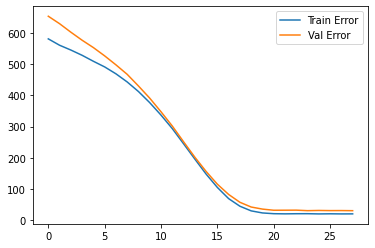

In [18]:
import matplotlib.pyplot as plt

plt.plot(hist['mse'],label='Train Error')
plt.plot(hist['val_mse'],label = 'Val Error')
plt.legend()

>> 2. 모델 평가

테스트 셋을 prediction 해봅시다

In [19]:
# prediction을 해봅시다. 
# 정규화를 해서 훈련하였으므로, prediction할때도 정규화 값을 넣습니다. 

y_test_pred = model.predict(x_test_scaled)

mse와 mae를 확인해봅시다. 

In [20]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'test MSE: {mse_test:.2f}, test MAE: {mae_test:.2f}')

test MSE: 23.40, test MAE: 3.27


가격에 대해 평균적으로 3.9 * $1000 달러의 오차를 가집니다. 

그래프를 그려서 확인해봅시다

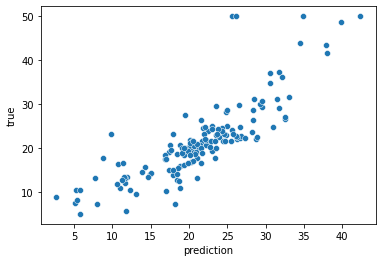

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=y_test_pred[:,0], y=y_test[:])  # 출력 shape을 고려하여 연산

plt.xlabel('prediction') # y축 제목
plt.ylabel('true') # x축 제목
plt.show()

Residual의 분포를 살펴봅시다

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


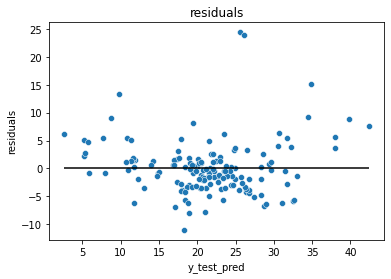

In [23]:
sns.scatterplot(y_test_pred[:,0], y_test-y_test_pred[:,0])
plt.title('residuals') # 타이틀
plt.xlabel('y_test_pred') # y축 제목
plt.ylabel('residuals') # x축 제목
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max())  # 수평선 그리기
plt.show()